In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

# Downloading SP500 adjusted close prices
data = yf.download("^GSPC", start='2018-01-05', end='2023-07-01')['Adj Close']

# Downloading Implied Volatility adjusted close prices
Implied_Vol = yf.download("^VIX", start='2018-02-01', end='2023-07-01')['Adj Close']

# Downloading 3 Month Treasury Yield data
Treasury_Yield = yf.download("^IRX", start='2018-02-06', end='2023-07-01')['Adj Close']

# Downloading SP500 Volume data
Volume = yf.download("^GSPC", start='2018-02-06', end='2023-07-01')['Volume']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [2]:
# Access files from Google Drive - all code was done on Google Colaboratory
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir("./gdrive/My Drive/Colab Notebooks/Applied Project/")

# Importing .csv file containing the S&P500 Twitter Sentiment Index
Sentiment_Index = pd.read_csv("Sentiment_Index.csv", index_col=0)

Mounted at /content/gdrive


In [3]:
# Changing annualized percentage Implied Volatility to daily format
Implied_Vol = Implied_Vol/(100*np.sqrt(252))

# Calculating returns
returns = data/data.shift(1) - 1

returns = returns.iloc[1:]
returns = pd.DataFrame(returns.values)

# Calculating 21-day lagged realized volatility of returns
lagged_realized_volatility = returns.rolling(window=21).std().dropna()

# Removing initial 20 days as we needed it for calculating the realized volatility only
returns = returns.iloc[20:]

In [4]:
# Spliting into 80:20 train and test datasets
returns_train = returns[:round(0.8*len(returns))]
returns_test = returns[round(0.8*len(returns)):]

# Originally extracted 3 days earlier for the lagged input for Neural Network Model
Implied_Vol_train = Implied_Vol[3:round(0.8*len(returns))+3]
Implied_Vol_test = Implied_Vol[round(0.8*len(returns))+3:]

In [5]:
!pip install arch
from arch import arch_model

# Defining and fittting a GARCH(1,1) model
garch_model = arch_model(returns_train, vol='Garch', p=1, q=1)

garch_results = garch_model.fit()

# Print the summary of the model
print(garch_results.summary())

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 916.4/916.4 kB 3.8 MB/s eta 0:00:00
Iteration:      1,   Func. Count:      6,   Neg. LLF: 5.047913360523163e+20
Iteration:      2,   Func. Count:     19,   Neg. LLF: 330996371.7448091
Iteration:      3,   Func. Count:     31,   Neg. LLF: 16579800769046.258
Iteration:      4,   Func. Count:     45,   Neg. LLF: 67308221.13553822
Iteration:      5,   Func. Count:     57,   Neg. LLF: 43917222.16592175
Iteration:      6,   Func. Count:     69,   Neg. LLF: 69989578117.16873
Iteration:      7,   Func. Count:     83,   Neg. LLF: 5788648997677165.0
Iteration:      8,   Func. Count:     98,   Neg. LLF: 4.167083986572461e+16
Iteration:      9,   Func. Count:    110,   Neg. LLF: -3477.6023469242873
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3477.6023456573057
            Iterations: 13
            Function evaluations: 110
            Gradient evaluations: 9
                     Constant Mean - GARCH Model

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001853. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [6]:
# Extracting the parameters of the GARCH model
parameters = garch_results.params

# Extracting the last conditional volatility from the Training set for forecasting
last_volatility = garch_results.conditional_volatility.values[-1]

# Defining a list to store conditional volatilities for the Test set
garch_forecasted_volatilities = np.array([last_volatility])

# Using the returns in the Test set to forecast the conditional volatilities
for i in range(len(returns_test[:-1])):
    forecasted_volatility = np.sqrt(parameters['omega'] +
                                    parameters['alpha[1]'] * returns_test.iloc[i]**2 +
                                    parameters['beta[1]'] * last_volatility**2)
    # Storing the forecasted volatility
    garch_forecasted_volatilities = np.append(garch_forecasted_volatilities,
                                              forecasted_volatility)

    # Updating the 'last_volatility' for the next iteration
    last_volatility = forecasted_volatility

# Calculating OOS-RMSE
GARCH_MSE = np.mean((Implied_Vol_test - garch_forecasted_volatilities) ** 2)
GARCH_RMSE = np.sqrt(GARCH_MSE)
print("The Root Mean Squared Error for the GARCH model is: ", GARCH_RMSE)

The Root Mean Squared Error for the GARCH model is:  0.0029762747869011


In [7]:
# Calculating R-Squared and Adjusted R-Squared
from sklearn.metrics import r2_score

r_squared = r2_score(Implied_Vol_test, garch_forecasted_volatilities)

# Calculating adjusted R-squared
n = len(Implied_Vol_test)
p = 1
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

print('The OOS R-squared is: ', r_squared)
print('The OOS Adjusted R-squared is: ',adjusted_r_squared)

The OOS R-squared is:  0.013744243593922456
The OOS Adjusted R-squared is:  0.010091444496122093


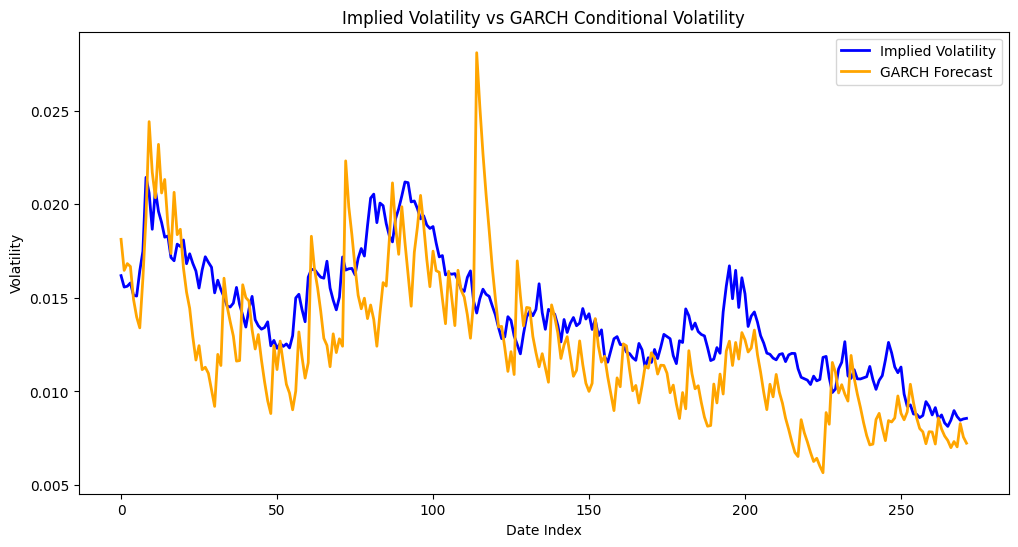

In [8]:
import matplotlib.pyplot as plt

# Plotting graph to compare actual IV against GARCH conditional volatilities for test set
x = range(len(Implied_Vol_test))

y1 = Implied_Vol_test
y2 = garch_forecasted_volatilities

plt.figure(figsize=(12, 6))

plt.plot(x, y1, label='Implied Volatility', color='blue', linestyle='-', linewidth=2)

plt.plot(x, y2, label='GARCH Forecast', color='orange', linestyle='-', linewidth=2)

plt.xlabel('Date Index')
plt.ylabel('Volatility')
plt.title('Implied Volatility vs GARCH Conditional Volatility')
plt.legend()

plt.show()

In [9]:
# Defining a dataframe to store all of the input variables and target variable
data = {
    # Excluding last day as we only want to forecast 1-day ahead Implied Volatility
    'Yield': Treasury_Yield.values[:-1],
    'Volume': Volume.values[:-1],
    'returns': returns.squeeze().values[:-1],
    'realized_vol': lagged_realized_volatility.squeeze().values[:-1],
    'Sentiment': Sentiment_Index.squeeze().values[:-1],
    # Carefully extracting the correct lags of IV
    'Implied_Vol_LAG1': Implied_Vol.values[3:-1],
    'Implied_Vol_LAG2': Implied_Vol.values[2:-2],
    'Implied_Vol_LAG3': Implied_Vol.values[1:-3],
    'Implied_Vol': Implied_Vol.values[4:]
}

df = pd.DataFrame(data)
df.head()

,Yield,Volume,returns,realized_vol,Sentiment,Implied_Vol_LAG1,Implied_Vol_LAG2,Implied_Vol_LAG3,Implied_Vol
0,1.488,5917350000,0.017441,0.012288,100.00,0.018886,0.023509,0.010904,0.017468
1,1.515,4646300000,-0.005002,0.012308,99.50,0.017468,0.018886,0.023509,0.021078
2,1.515,5333840000,-0.037536,0.014631,95.76,0.021078,0.017468,0.018886,0.018306
3,1.525,5690110000,0.014936,0.015141,97.16,0.018306,0.021078,0.017468,0.016133
4,1.535,4069220000,0.013915,0.015422,98.42,0.016133,0.018306,0.021078,0.015730


In [10]:
# Rescaling the input variables
from sklearn.preprocessing import MinMaxScaler

# Scaling by Min-Max
scaler = MinMaxScaler()

# Scaling the data ready for Neural Network input Tensors
scaled_data = scaler.fit_transform(df.iloc[:,:-1])

# Create a new DataFrame containing the scales values
scaled_df = pd.DataFrame(scaled_data, columns=df.columns[:-1])

In [19]:
# Creating the first LSTM model with pre-defined hyperparameters

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from sklearn.model_selection import train_test_split


# Pre-defining hyperparameters
d_1 =64 # output dimension of the first LSTM layer
d_2 = 64# output dimension of the second LSTM layer
K = 1 # Output dimension of the last layer
N_epochs = 10
N_batch_size =64

X = scaled_df.iloc[:, :].values
y = df.iloc[:, -1].values

# Splitting data into Training and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshaping X into suitable LSTM input tensors
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Creating a neural network with 2 LSTM layers and 2 dense layer
model = Sequential([
    LSTM(d_1, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    LSTM(d_2),
    Dense(32, activation = 'linear'),
    Dense(K, activation = 'linear')
])

# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model on the Training dataset
history = model.fit(X_train, y_train, epochs=N_epochs, batch_size=N_batch_size, validation_data=(X_test, y_test))

# Predicting the OOS Implied Volatility using NN model
NN_predictions = model.predict(X_test)

# Calculating OOS RMSE
NN_mse = np.mean((y_test - NN_predictions.flatten()) ** 2)
NN_rmse = np.sqrt(NN_mse)
print("The Root Mean Squared Error for the Neural Network model is: ", NN_rmse)

Epoch 1/10
17/17 [==============================] - 8s 64ms/step - loss: 6.0354e-05 - val_loss: 3.8337e-05
Epoch 2/10
17/17 [==============================] - 0s 11ms/step - loss: 8.5474e-06 - val_loss: 2.5829e-06
Epoch 3/10
17/17 [==============================] - 0s 11ms/step - loss: 3.9496e-06 - val_loss: 2.1347e-06
Epoch 4/10
17/17 [==============================] - 0s 11ms/step - loss: 2.9976e-06 - val_loss: 2.0627e-06
Epoch 5/10
17/17 [==============================] - 0s 10ms/step - loss: 2.8461e-06 - val_loss: 1.9068e-06
Epoch 6/10
17/17 [==============================] - 0s 12ms/step - loss: 2.5059e-06 - val_loss: 1.0829e-06
Epoch 7/10
17/17 [==============================] - 0s 8ms/step - loss: 2.3078e-06 - val_loss: 1.4563e-06
Epoch 8/10
17/17 [==============================] - 0s 8ms/step - loss: 2.2499e-06 - val_loss: 1.2238e-06
Epoch 9/10
17/17 [==============================] - 0s 8ms/step - loss: 2.2317e-06 - val_loss: 1.3743e-06
Epoch 10/10
9/9 [=======================

In [12]:
NN_predictions = model.predict(X_test)

NN_r_squared = r2_score(y_test, NN_predictions)

n = len(y_test)
p = 8
NN_adjusted_r_squared = 1 - (1 - NN_r_squared) * (n - 1) / (n - p - 1)

print('The OOS R-squared is: ', NN_r_squared)
print('The OOS Adjusted R-squared is: ', NN_adjusted_r_squared)

9/9 [==============================] - 0s 8ms/step
The OOS R-squared is:  0.9089655737970382
The OOS Adjusted R-squared is:  0.9061964657756554


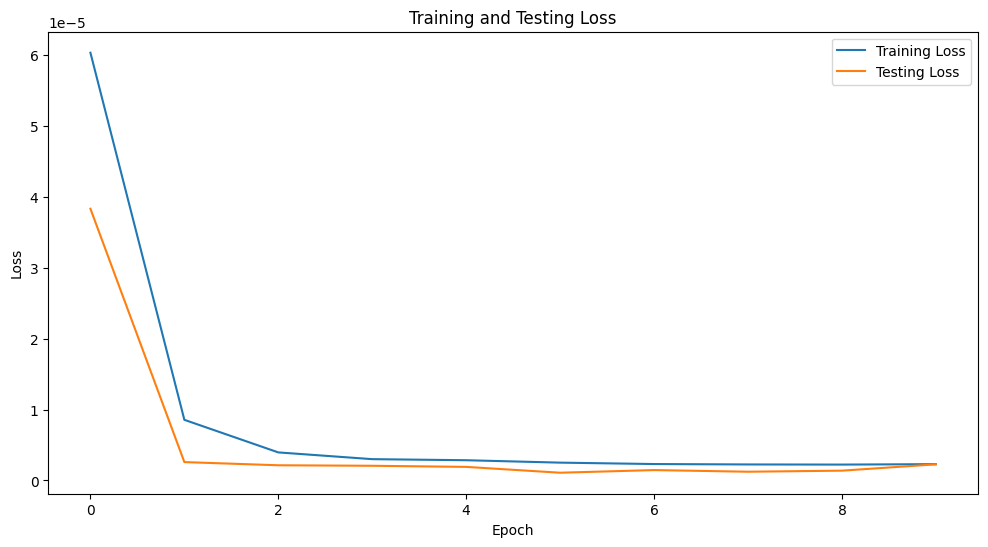

In [20]:
# Plotting a graph of the Training and Testing loss for each Epoch
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()

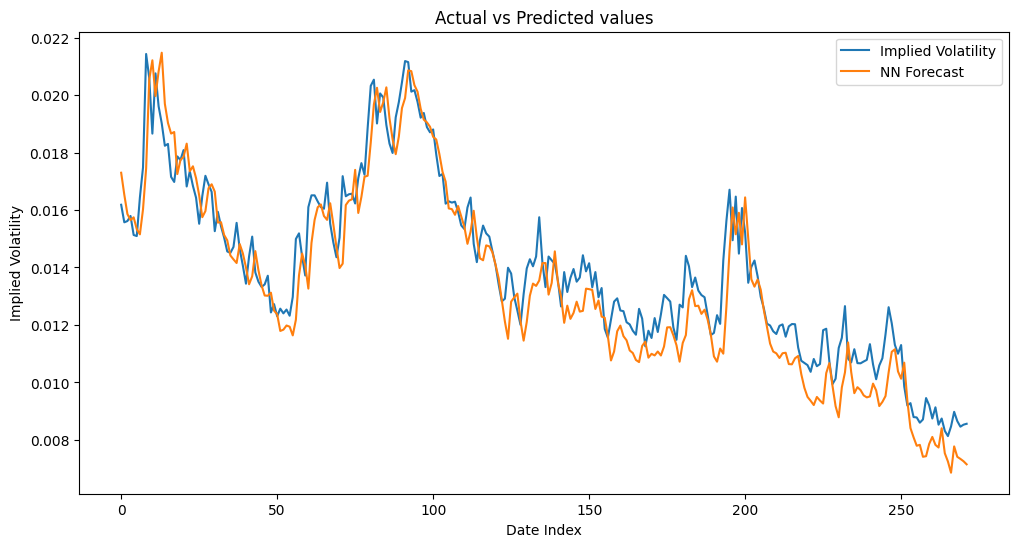

In [16]:
# Plot the true values and predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Implied Volatility')
plt.plot(NN_predictions, label='NN Forecast')
plt.xlabel('Date Index')
plt.ylabel('Implied Volatility')
plt.title('Actual vs Predicted values')
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

# Creating a function that creates our NN model with different hyperparameters
def create_model(lstm_1,lstm_2,dense):
    model = Sequential()
    model.add(LSTM(lstm_1, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(LSTM(lstm_2))
    model.add(Dense(dense, activation='linear'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Defining the grid search of parameters
param_grid = param_grid = {
    'lstm_1': [32, 64, 128],
    'lstm_2': [32, 64, 128],
    'dense': [16, 32, 64]
}


# Creating a TimeSeriesSplit for crossvalidation when optimising hyperparameters
tscv = TimeSeriesSplit(n_splits=5)

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
model = KerasRegressor(build_fn=create_model, epochs=10, batch_size=32, verbose=0)

# Perform grid search with cross-validation
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv)
grid_result = grid.fit(X_train, y_train)

# Print the best parameters and corresponding accuracy
print("The Best parameters: ", grid_result.best_params_)

<ipython-input-16-04a60739407d>:27: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, epochs=10, batch_size=32, verbose=0)


The Best parameters:  {'dense': 64, 'lstm_1': 128, 'lstm_2': 128}


In [ ]:
best_model = grid_result.best_estimator_.model

# Calculating OOS RMSE
NN_predictions = best_model.predict(X_test)

NN_mse = np.mean((y_test - NN_predictions.flatten()) ** 2)
NN_rmse = np.sqrt(NN_mse)
print("The Root Mean Squared Error for the Neural Network model is: ", NN_rmse)

9/9 [==============================] - 0s 3ms/step
The Root Mean Squared Error for the Neural Network model is:  0.0009713980699392585


In [ ]:
NN_r_squared = r2_score(y_test, NN_predictions)

n = len(y_test)
p = 8
NN_adjusted_r_squared = 1 - (1 - NN_r_squared) * (n - 1) / (n - p - 1)

print('The OOS R-squared is: ', NN_r_squared)
print('The OOS Adjusted R-squared is: ', NN_adjusted_r_squared)

The OOS R-squared is:  0.8949398605508077
The OOS Adjusted R-squared is:  0.8917441148641402


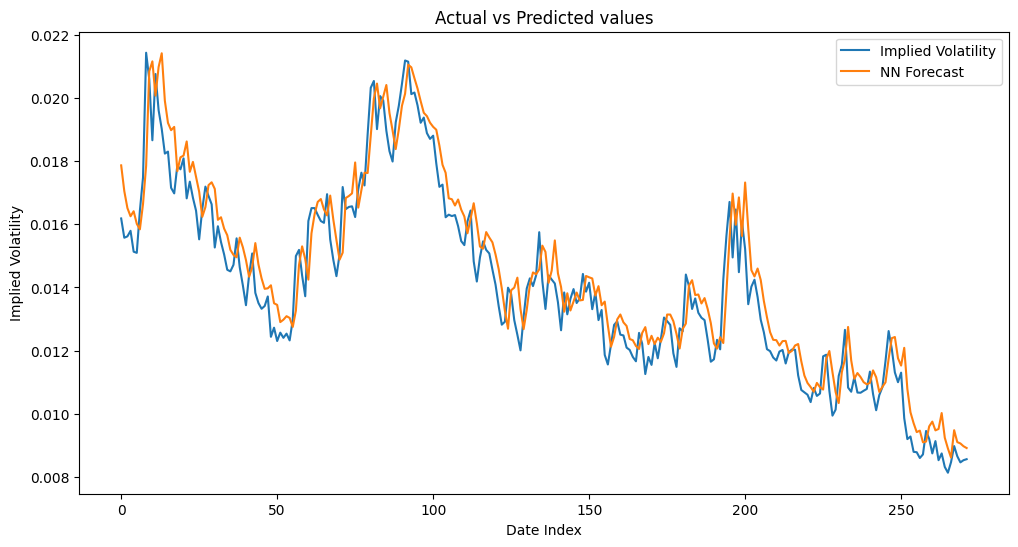

In [ ]:
# Plotting actual IV against NN forecasted IV for test set
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Implied Volatility')
plt.plot(NN_predictions, label='NN Forecast')
plt.xlabel('Date Index')
plt.ylabel('Implied Volatility')
plt.title('Actual vs Predicted values')
plt.legend()
plt.show()

In [ ]:
# Importing L2 regularization function
from tensorflow.keras.regularizers import L2

# Extracting the optimal hyperparameters
LSTM1 = grid_result.best_params_['lstm_1']
LSTM2 = grid_result.best_params_['lstm_2']
DENSE = grid_result.best_params_['dense']

# Defining NN model with the addition of L2 Regularization
model_REG = Sequential([
    LSTM(LSTM1, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, kernel_regularizer= L2(0.001)),
    LSTM(LSTM2),
    Dense(DENSE, activation = 'linear'),
    Dense(K, activation = 'linear')
])

# Compiling the model
model_REG.compile(optimizer='adam', loss='mean_squared_error')

# Training the model on the Training dataset
history_REG = model_REG.fit(X_train, y_train, epochs=N_epochs, batch_size=N_batch_size, validation_data=(X_test, y_test))

# Predicting the OOS Implied Volatility using NN model
NN_REG_predictions = model_REG.predict(X_test)

# Calculating OOS RMSE
NN_REG_mse = np.mean((y_test - NN_REG_predictions.flatten()) ** 2)
NN_REG_rmse = np.sqrt(NN_REG_mse)
print("The Root Mean Squared Error for the Neural Network model is: ", NN_REG_rmse)


Epoch 1/10
34/34 [==============================] - 7s 38ms/step - loss: 0.0099 - val_loss: 0.0053
Epoch 2/10
34/34 [==============================] - 0s 11ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 3/10
34/34 [==============================] - 0s 12ms/step - loss: 8.3578e-04 - val_loss: 3.6699e-04
Epoch 4/10
34/34 [==============================] - 0s 12ms/step - loss: 1.9324e-04 - val_loss: 7.9318e-05
Epoch 5/10
34/34 [==============================] - 0s 12ms/step - loss: 4.3042e-05 - val_loss: 1.8843e-05
Epoch 6/10
34/34 [==============================] - 0s 12ms/step - loss: 1.4165e-05 - val_loss: 7.5447e-06
Epoch 7/10
34/34 [==============================] - 0s 10ms/step - loss: 8.8927e-06 - val_loss: 1.1530e-05
Epoch 8/10
34/34 [==============================] - 0s 11ms/step - loss: 8.1630e-06 - val_loss: 8.4355e-06
Epoch 9/10
34/34 [==============================] - 0s 12ms/step - loss: 8.4899e-06 - val_loss: 9.4139e-06
Epoch 10/10
9/9 [==============================] - 1s

In [ ]:
NN_r_squared = r2_score(y_test, NN_REG_predictions)

n = len(y_test)
p = 8
NN_adjusted_r_squared = 1 - (1 - NN_r_squared) * (n - 1) / (n - p - 1)

print('The OOS R-squared is: ', NN_r_squared)
print('The OOS Adjusted R-squared is: ', NN_adjusted_r_squared)

The OOS R-squared is:  -0.28344534202726557
The OOS Adjusted R-squared is:  -0.32248550452239155


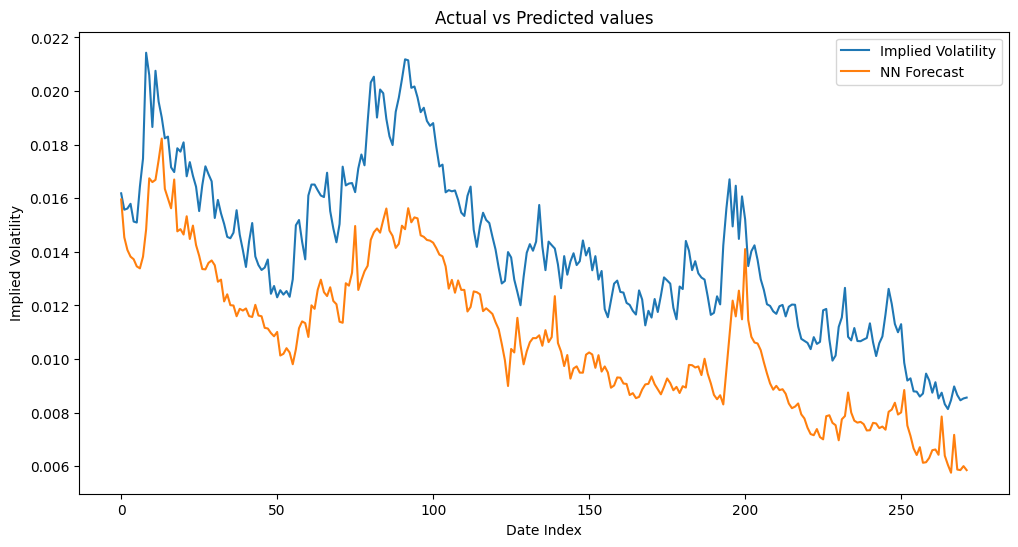

In [ ]:
# Plot the true IV against the NN forecasted IV for test data
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Implied Volatility')
plt.plot(NN_REG_predictions, label='NN Forecast')
plt.xlabel('Date Index')
plt.ylabel('Implied Volatility')
plt.title('Actual vs Predicted values')
plt.legend()
plt.show()